In [1168]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [1169]:
ts = 1e-2
perturb_percentage = 1

num = [1]
den = [1, -1.479, 0.48]
s = tf('s')
G = tf(num,den, ts, display_format='zpk')

k_0 = 2.87
p1_0 = 0.9975
p2_0 = 0.7959

k = k_0 + (np.random.uniform(low=-1, high=1)*perturb_percentage*k_0); k = max(1,k)
p2 = p2_0 + (np.random.uniform(low=-1, high=1)*perturb_percentage*p2_0); p2 = min(p2,0.9)

G = zpk([],[p1_0, p2],k,ts)

In [1170]:
W

TransferFunction(array([0.00626349]), array([ 1.        , -0.99373651]), 0.01)

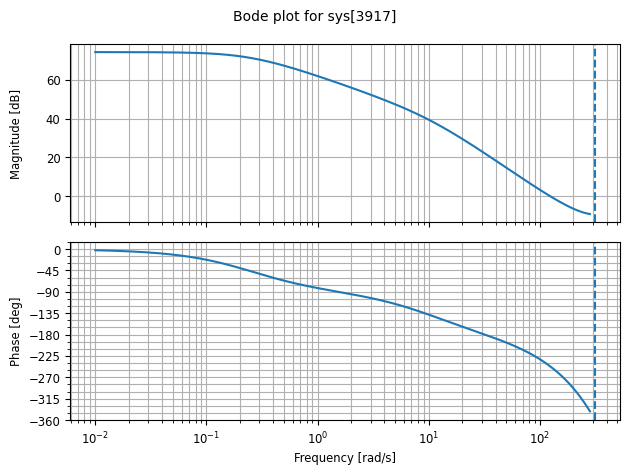

In [1171]:
bode(G)
plt.show()

In [1172]:
from utils import prbs, random_signal
fs = 1/ts
T = 11
t = np.arange(0, T, ts)
u = np.random.normal(0, 2, t.shape)

In [1173]:
from u_estimate import u_estimate
U = u_estimate(u, ts)

<>:12: DeprecationWarning: invalid escape sequence '\m'
<>:12: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_650089/2128368418.py:12: DeprecationWarning: invalid escape sequence '\m'
  plt.plot(t, y_0, label="$y^{\mathrm{0}}$")


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

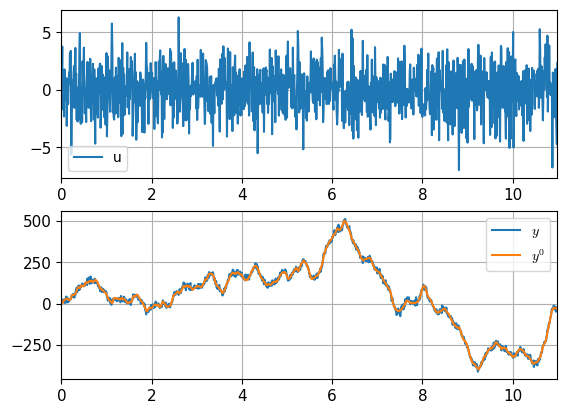

In [1174]:
y_0, t, _ = lsim(G, u, t)
y = y_0 + np.random.normal(0, 10, t.shape)
plt.subplot(211)
plt.plot(t, u, label="u")
# plt.xlim([10, 20])
# plt.ylim([-5000,5000])
plt.legend()

plt.subplot(212)
# plt.plot(t, y_ideal, label="y")
plt.plot(t, y, label="$y$")
plt.plot(t, y_0, label="$y^{\mathrm{0}}$")
# plt.xlim([10, 20])
# plt.ylim([-12,12])
plt.legend()

In [1175]:
import control
z = control.TransferFunction([1, 0], [1], dt=ts)

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


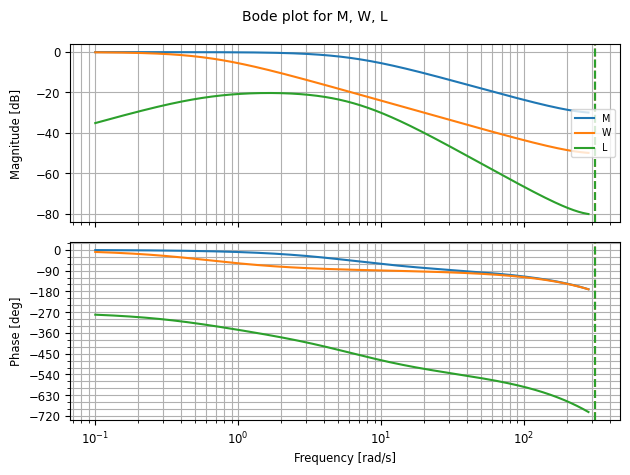

In [1176]:
# VRFT
s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')
M.name = 'M'
# M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
W = 1/(1 + (10*tau/(2*np.pi))*s) # tf([1],[1])
# W = tf([1],[1])
W = c2d(W, ts, 'matched')
W.name = 'W'

use_prefilter = True

if use_prefilter:
   L = minreal( minreal((1 - M)*M)*minreal(W*U**-1) )
else:
   L = tf([1],[1])
L.name = 'L'

# T_cl = tau + 10#0.5
# t_cl = np.arange(0, T_cl, ts)
# y_d, _ = step(M, t_cl)

bode(M, W, L)
plt.show()
# plt.subplot(212)
# plt.plot(t_cl, y_d)
# plt.plot(t_cl, y_d)

In [1177]:
M

TransferFunction(array([0.06089863]), array([ 1.        , -0.93910137]), 0.01)

In [1178]:
L

TransferFunction(array([ 3.81437816e-04, -3.53253237e-04, -2.81845796e-05]), array([ 1.        , -2.87193925,  2.74835001, -0.87638754,  0.        ]), 0.01)

In [1179]:
# vrft
u_L = lsim(L, u, t)[0]
y_L = lsim(L, y, t)[0]
M_proper = z*M
r_v = lsim(M_proper**(-1), y_L, t)[0]
e_v = r_v - y_L

In [1180]:
controller_type = "PID"

B=[tf([1],[1],ts),
   tf(ts*np.array([1, 1]),2*np.array([1, -1]),ts)]
   
if controller_type == "PID":
   B.append(tf(np.array([2, -2]),ts*np.array([3, -1]),ts))

In [1181]:
import cvxpy as cp

theta = cp.Variable(3)


u_theta = theta[0]*lsim(B[0], e_v, t)[0] + theta[1]*lsim(B[1], e_v, t)[0]

if controller_type == "PID":
   u_theta += theta[2]*lsim(B[2], e_v, t)[0]

In [1182]:
cost = cp.sum_squares(u_L - u_theta)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()
theta_sol = theta.value

In [1183]:
C = theta_sol[0]*B[0] + theta_sol[1]*B[1]

if controller_type == "PID":
   C += theta_sol[2]*B[2]

F = C*G/(1 + C*G)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

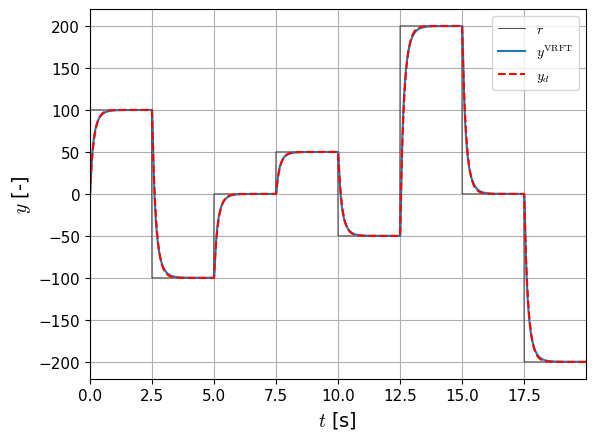

In [1184]:

# y_cl, _ = step(F, t_cl)
# plt.plot(t_cl, y_cl, label='y')
# plt.plot(t_cl, y_d, label='y_d')
# plt.legend()
# plt.show()
T_CL = 20#seq_len*ts
t_CL = np.arange(0, T_CL, ts)
r = np.zeros(len(t_CL))

r = np.zeros(t_CL.shape)
r[t_CL < 10] = 100
r[(t_CL >= 2.5) & (t_CL < 5)] = -100
r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
r[(t_CL >= 7.5) & (t_CL < 10)] = 50
r[(t_CL >= 10.) & (t_CL < 12.5)] = -50
r[(t_CL >= 12.5) & (t_CL < 15.)] = 200
r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
r[(t_CL >= 17.5) & (t_CL < 20.0)] = -200

y_d = lsim(M, r, t_CL, return_x=False)[0]
y_cl = lsim(F, r, t_CL, return_x=False)[0]

plt.plot(t_CL, r, color='k', linewidth=0.5, label='$r$')
plt.plot(t_CL, y_cl, label=r'$y^{\mathrm{VRFT}}$')
plt.plot(t_CL, y_d, color='r', linestyle='--', label='$y_d$')
plt.xlabel("$t$ [s]")
plt.ylabel("$y$ [-]")
plt.legend()
plt.margins(x=0)
plt.show()